# Process datasets and import results into Granta MI

Load raw data from a *.csv* file and run a typical tensile data analysis to extract values for *Ultimate Tensile Strength*, *Young's Modulus* and *Elongation at failure*. Import the results into Granta MI.

## Load data from CSV

The raw *Load* vs *Displacement* data is stored in a CSV file. Import the data directly into a DataFrame using the `pandas` function `.read_csv()`.

In [1]:
import pandas as pd

df_raw = pd.read_csv('raw_test_data.csv')
df_raw.head()

,Displacement [mm],Load [N]
0,0.000000,0.000
1,0.005282,273.392
2,0.005282,307.173
3,0.006010,331.741
4,0.006738,352.556


The convention in this example is that all properties are in SI units unless otherwise specified. Create a new DataFrame, converting *Displacement* to SI units and renaming both columns.

In [2]:
df = pd.DataFrame()
df['Displacement'] = df_raw['Displacement [mm]'] / 1e3
df['Load'] = df_raw['Load [N]']
df.head()

,Displacement,Load
0,0.000000,0.000
1,0.000005,273.392
2,0.000005,307.173
3,0.000006,331.741
4,0.000007,352.556


## Process the data

### Plot Load-Displacement data

This code snippet is optional, and is included to increase the size of all plots generated in this notebook.

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 125

Use `matplotlib` to plot the Load-Displacement curve. For this plot, we've divided `df.Load` by `1e3` so the y-axis is displayed in kN.

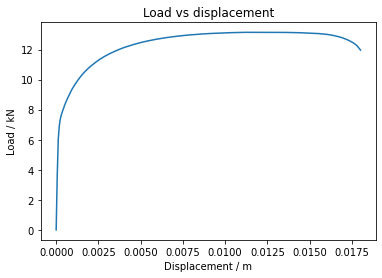

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(df.Displacement, df.Load / 1e3)
ax.set_xlabel('Displacement / m')
ax.set_ylabel('Load / kN')
_ = ax.set_title('Load vs displacement')

### Convert Load-Displacement to Stress-Strain

Converting the Load-Displacement curve into Stress-Strain requires the gauge length and area, given here as constants in SI units. In a full workflow, these values can be loaded from a source file. 

Calculate the *Stress* and *Strain* and store as new columns in the DataFrame.

In [5]:
GAUGE_WIDTH = 0.0150068
GAUGE_THICKNESS = 0.0015077
GAUGE_LENGTH = 0.07997724

df['Strain'] = df.Displacement / GAUGE_LENGTH
gauge_area = GAUGE_WIDTH * GAUGE_THICKNESS
df['Stress'] = df.Load / gauge_area
df.head()

,Displacement,Load,Strain,Stress
0,0.000000,0.000,0.000000,0.000000e+00
1,0.000005,273.392,0.000066,1.208322e+07
2,0.000005,307.173,0.000066,1.357626e+07
3,0.000006,331.741,0.000075,1.466210e+07
4,0.000007,352.556,0.000084,1.558207e+07


Now create a plot of Stress-Strain:

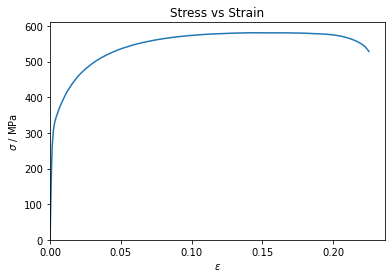

In [6]:
fig, ax = plt.subplots()
ax.plot(df.Strain, df.Stress / 1e6, zorder=0)
ax.set_xlabel('$\epsilon$')
ax.set_ylabel('$\sigma$ / MPa')
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

_ = ax.set_title('Stress vs Strain')

Since the plastic region extends over a large strain range, it is difficult to see detail in the elastic region. 

Create an inset and plot the elastic and yield region only.

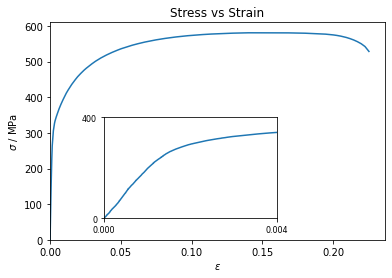

In [7]:
# [left, bottom, width, height] relative to the figure
ax_inset = fig.add_axes([0.25, 0.2, 0.4, 0.35])

ax_inset.plot(df.Strain, df.Stress / 1e6, label='Tensile response', zorder=0)
ax_inset.set_xlim(0, 0.004)
ax_inset.set_xticks([0, 0.004])

ax_inset.set_ylim(0, 400)
ax_inset.set_yticks([0, 400])

ax_inset.tick_params(axis='both', which='major', labelsize=8)
fig

### Calculate Ultimate tensile strength

*Ultimate tensile strength* can be calculated by taking the maximum value of the `df.Stress` column. 

Calculate and store the tensile strength in SI units and MPa (the latter will be used later).

In [8]:
tens_strength = df.Stress.max()
tens_strength_MPa = tens_strength / 1e6
print(f'Ultimate tensile strength: {tens_strength_MPa:.2f} MPa')

Ultimate tensile strength: 581.13 MPa


Add a marker and annotation on the stress-strain plot above, showing the location and value of the *Ultimate tensile
strength*.

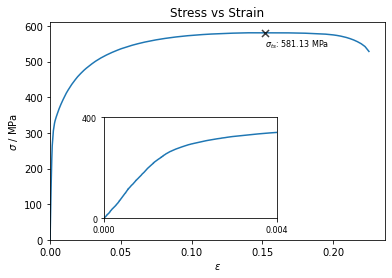

In [9]:
strain_at_uts = df.Strain[df.Stress == tens_strength].iloc[0]
ax.scatter(x=[strain_at_uts], y=[tens_strength_MPa], color='black', marker='x', alpha=0.75, s=50, zorder=1)
ax.annotate(rf'$\sigma_{{ts}}$: {tens_strength_MPa:.2f} MPa',
            xy=(strain_at_uts, tens_strength_MPa),
            xytext=(0,-14),
            textcoords='offset points',
            fontsize=8)
fig

### Calculate Young's modulus

Calculate *Young's modulus* by taking the gradient of the Stress-Strain curve between 5% and 25% of the total tensile strength (chordal fit method). There is no interpolation, because the Stress-Strain values closest to the 5% and 25% bounds are used.

In [10]:
LOWER_FRACTION = 0.05
UPPER_FRACTION = 0.25

def get_stress_strain_at_fraction_of_tensile_strength(fraction):
    stress_bound = tens_strength * fraction
    stress_difference = df.Stress - stress_bound
    nearest_row_number = stress_difference.abs().argsort()[0]
    nearest_row = df.iloc[nearest_row_number]
    return nearest_row.Strain, nearest_row.Stress
    
lower_strain, lower_stress = get_stress_strain_at_fraction_of_tensile_strength(LOWER_FRACTION)
upper_strain, upper_stress = get_stress_strain_at_fraction_of_tensile_strength(UPPER_FRACTION)

youngs_modulus = (upper_stress - lower_stress) / (upper_strain - lower_strain)
print(f"Young's modulus ({LOWER_FRACTION:.0%}-{UPPER_FRACTION:.0%} tensile strength): {youngs_modulus / 1e9:.2f} GPa")

Young's modulus (5%-25% tensile strength): 204.65 GPa


Add the chordal fit to the inset plot.

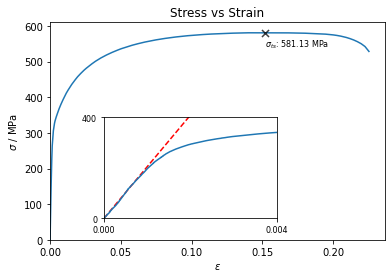

In [11]:
stress_linear_fit = df.Strain * youngs_modulus
ax_inset.plot(df.Strain, stress_linear_fit / 1e6, 'r--', label="Young's modulus", zorder=-1)

fig

### Calculate 0.2% offset yield stress

The offset yield stress is determined by calculating the intercept between the chordal fit line and the stress response.

First add the offset chordal fit line to the plot, to show where the yield stress lies.

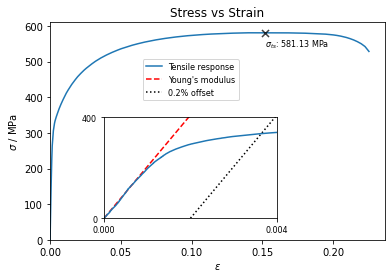

In [12]:
STRAIN_OFFSET = 0.002

strain_offset = df.Strain + STRAIN_OFFSET
ax_inset.plot(strain_offset, stress_linear_fit / 1e6, 'k:', label=f'0.2% offset', zorder=-1)

handles, labels = ax_inset.get_legend_handles_labels()
legend_position = (0.575, 0.85)
ax.legend(handles, labels, bbox_to_anchor=legend_position, prop={'size': 8})
fig

Calculate the difference between the solid blue and dotted black lines, then find the values immediately before and after the intercept. Perform a linear interpolation to find the exact value of the yield stress.

In [13]:
df['find_intercept'] = df.Stress - youngs_modulus * (df.Strain - STRAIN_OFFSET)
first_row_index_above_intercept = \
    df.loc[df.find_intercept < 0].sort_values(by=['find_intercept'], ascending=False).index[0]
y_1 = df.Stress.iloc[first_row_index_above_intercept]
x_1 = df.find_intercept.iloc[first_row_index_above_intercept]

last_row_index_below_intercept = \
    df.loc[df.find_intercept >= 0].sort_values(by=['find_intercept'], ascending=True).index[0]
y_0 = df.Stress.iloc[last_row_index_below_intercept]
x_0 = df.find_intercept.iloc[last_row_index_below_intercept]

yield_stress = y_0 + (-x_0) * (y_1 - y_0) / (x_1 - x_0)
strain_at_yield = yield_stress / youngs_modulus + STRAIN_OFFSET

yield_stress_MPa = yield_stress / 1e6
print(f'0.2% offset yield stress: {yield_stress:.2f} MPa')  

0.2% offset yield stress: 335555698.60 MPa


Plot the *0.2% offset yield stress* on the Stress-Strain plot. This time, plot the marker on both the full and inset
axes, and annotate the inset.

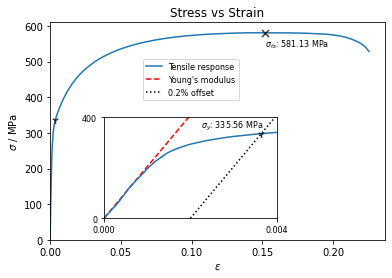

In [14]:
ax.scatter(x=[strain_at_yield], y=[yield_stress_MPa], color='black', marker='1', alpha=0.75, s=50, zorder=1)
ax_inset.scatter(x=[strain_at_yield], y=[yield_stress_MPa], color='black', marker='1', alpha=0.75, s=50, zorder=1)
ax_inset.annotate(rf'$\sigma_y$: {yield_stress_MPa:.2f} MPa',
            xy=(strain_at_yield, yield_stress_MPa),
            xytext=(-60,6),
            textcoords='offset points',
            fontsize=8)
fig

### Calculate Elongation at failure

The data has been pre-processed before import, so the last point in the data series is the failure point.

In [15]:
stress_at_break = df.Stress.iloc[-1]
total_strain_at_break = df.Strain.iloc[-1]
elastic_strain_at_break = stress_at_break / youngs_modulus
elongation = total_strain_at_break - elastic_strain_at_break
print(f'Elongation at failure: {elongation:.2%}')  

Elongation at failure: 22.27%


Plot the *Elongation at failure* on the full-range axes, and add a line between the failure point and the
elongation value. The legend updates to include all lines on both sets of axes.

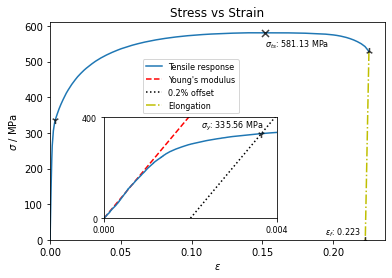

In [16]:
ax.plot([total_strain_at_break, elongation], [stress_at_break / 1e6, 0], "y-.", label='Elongation', zorder=-1)
ax.scatter(x=[total_strain_at_break, elongation],
           y=[stress_at_break / 1e6, 0],
           color='black',
           marker='2',
           alpha=0.75,
           s=50,
           zorder=1)

inset_handles, inset_labels = ax_inset.get_legend_handles_labels()
ax_handles, ax_labels = ax.get_legend_handles_labels()
handles = inset_handles + ax_handles
labels = inset_labels + ax_labels
ax.get_legend().remove()
ax.legend(handles, labels, bbox_to_anchor=legend_position, prop={'size': 8})

ax.annotate(rf'$\epsilon_f$: {elongation:.3}',
            xy=(elongation, 0),
            xytext=(-40,5),
            textcoords='offset points',
            fontsize=8)
fig

### Calculate True Stress-Strain

Since there is a 1:1 relationship between engineering and true stress-strain values, *True Stress-Strain* is added to the DataFrame as additional columns.

In [17]:
import numpy as np

ts_position = df.Stress[df.Stress == tens_strength].index[0]

# true strain = ln(1 + eng strain)
df['True_Strain'] = np.log(1 + df.Strain[df.Strain.index <= ts_position])

# true stress = eng stress * (1 + eng strain)
df['True_Stress'] = df.Stress[df.Stress.index <= ts_position] * (1 + df.True_Strain)
df.head()

,Displacement,Load,Strain,Stress,find_intercept,True_Strain,True_Stress
0,0.000000,0.000,0.000000,0.000000e+00,4.093098e+08,0.000000,0.000000e+00
1,0.000005,273.392,0.000066,1.208322e+07,4.078764e+08,0.000066,1.208402e+07
2,0.000005,307.173,0.000066,1.357626e+07,4.093694e+08,0.000066,1.357715e+07
3,0.000006,331.741,0.000075,1.466210e+07,4.085924e+08,0.000075,1.466320e+07
4,0.000007,352.556,0.000084,1.558207e+07,4.076494e+08,0.000084,1.558338e+07


Create a new plot to compare Engineering and True Stress-Strain.

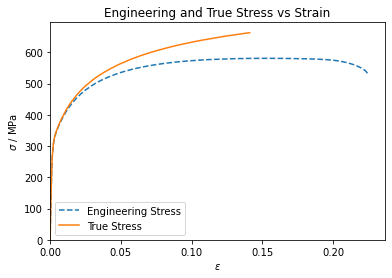

In [18]:
fig, ax = plt.subplots()
ax.plot(df.Strain, df.Stress / 1e6, label='Engineering Stress', linestyle='--')
ax.plot(df.True_Strain, df.True_Stress / 1e6, label='True Stress')
ax.set_xlabel('$\epsilon$')
ax.set_ylabel('$\sigma$ / MPa')
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.legend()
_ = ax.set_title('Engineering and True Stress vs Strain')

### Calculate True Stress-True Plastic Strain

Create a new DataFrame to store the *True Stress-True Plastic Strain*, since the x axis is different to *Stress-Strain*.

In [19]:
df_plastic = pd.DataFrame()
plastic_strain = df.True_Strain - df.True_Stress / youngs_modulus - STRAIN_OFFSET
df_plastic['Strain'] = plastic_strain[plastic_strain > 0]

# Get only the stress values with a corresponding strain
df_plastic['Stress'] = df.True_Stress.align(df_plastic.Strain, join='right')[0]

# Manually add the first point Strain = 0, Stress = yield stress
first_point = pd.DataFrame({'Strain': [0], 'Stress': [yield_stress]})
df_plastic = pd.concat([first_point, df_plastic], ignore_index=True)
df_plastic.head()

,Strain,Stress
0,0.000000,3.355557e+08
1,0.000008,3.370594e+08
2,0.000029,3.374152e+08
3,0.000050,3.377409e+08
4,0.000067,3.380495e+08


Plot *True Stress-True Plastic Strain*. Force the x limit to be 0, but not the y limit (the curve starts at the *Yield stress*).

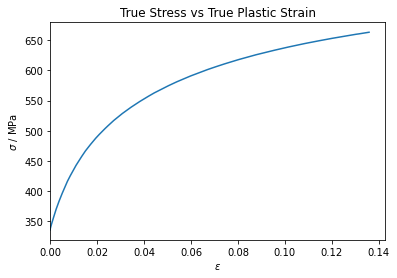

In [20]:
df_plastic['Stress_MPa'] = df_plastic.Stress / 1e6

fig, ax = plt.subplots()
ax.plot(df_plastic.Strain, df_plastic.Stress_MPa, label='True Stress')
ax.set_xlabel('$\epsilon$')
ax.set_ylabel('$\sigma$ / MPa')
ax.set_xlim(left=0)
_ = ax.set_title('True Stress vs True Plastic Strain')

## Import data and results into Granta MI

Finally, import the raw data, processed data and results into a new Granta MI record. 

Connect to Granta MI and specify a database and table.

In [21]:
from GRANTA_MIScriptingToolkit import granta as mpy
session = mpy.connect('localhost', autologon=True)
db = session.get_db('MI Training')
tensile_test_table = db.get_table('Tensile Test Data')

Create a new record to import the data into, using `datetime.now()` to ensure the record name is unique. 

At this stage, the record has only been created in the MI Scripting Toolkit. The changes will be pushed to Granta MI when `session.update()` is called at the end of the notebook.

In [22]:
from datetime import datetime

now = datetime.now().strftime("%c")
record_name = 'Tensile analysis {}'.format(now)

record = tensile_test_table.path_from(tensile_test_table, ['Data Analytics'], record_name)

### Create and populate point attributes

Define a function to write a dict of attribute name-value pairs to point attributes on the record. Each dict will
contain values with a single unit.

In [23]:
def write_points(attrs, unit):
    for name, value in attrs.items():
        a = record.attributes[name]
        a.points = [value]
        a.unit = unit
        record.set_attributes([a])

Build the dicts of attribute name-value pairs and call the function above on each. (The strain values are dimensionless but
will be imported as a percentage, so they are multiplied by 100 before import.)

In [24]:
stress_attrs = {'Ultimate Tensile Strength': tens_strength,
                "Young's Modulus (11-axis)": youngs_modulus,
                '0.2% Offset Yield Stress': yield_stress}
strain_attrs = {'Strain at Ultimate Tensile Strength': strain_at_uts * 100,
                'Elongation': elongation * 100,
                'Strain at Tensile Failure': total_strain_at_break * 100}
length_attrs = {'Gauge Length': GAUGE_LENGTH,
                'Gauge Width': GAUGE_WIDTH,
                'Gauge Thickness': GAUGE_THICKNESS}
area_attrs = {'Gauge Area': gauge_area}

write_points(stress_attrs, 'Pa')
write_points(strain_attrs, '%')
write_points(length_attrs, 'm')
write_points(area_attrs, 'm^2')

### Create and populate text attributes

Define a similar function for text attributes:

In [25]:
def write_text(attrs):
    for name, value in attrs.items():
        a = record.attributes[name]
        a.value = value
        record.set_attributes([a])

Define the dict of text attributes, and call the function above. We've defined the attribute values manually, but they could easily be read from the source file.

In [26]:
range_text = f'Linear fit between [{LOWER_FRACTION:.1%}:{UPPER_FRACTION:.1%}] of Tensile strength'
text_attrs = {"Young's Modulus Calculation": 'Chord',
              'Test Type': 'Tensile',
              'Testing Standards': 'ASTM E8',
              'Alloy': 'AMS 6520',
              'Modulus Calculation Range': range_text}
write_text(text_attrs)

### Create and populate functional attributes

Finally, define a function to import functional attributes.

In [27]:
def write_functional(attr_name, y_unit, x_unit, x_name, y_values, x_values):
    a = record.attributes[attr_name]
    a.unit = y_unit
    a.parameters[x_name].unit = x_unit
    a.xaxis[x_name] = True
    for x, y in zip(x_values, y_values):
        a.add_point({'y': y, x_name: x})
    record.set_attributes([a])

Call the function for each curve generated in this script.

In [28]:
write_functional(attr_name='Load vs Displacement',
                y_unit='N',
                x_unit='m',
                x_name='Displacement',
                y_values = df.Load,
                x_values = df.Displacement)

write_functional(attr_name='Tensile Response (11 axis)',
                y_unit='Pa',
                x_unit='strain',
                x_name='Strain',
                y_values = df.Stress,
                x_values = df.Strain)

write_functional(attr_name='True Stress vs True Plastic Strain',
                y_unit='Pa',
                x_unit='strain',
                x_name='Strain',
                y_values = df_plastic.Stress,
                x_values = df_plastic.Strain)

### Write your changes to Granta MI

In [29]:
session.update([record])

[<Record long name:Tensile analysis Tue May 10 23:50:06 2022>]